In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers, Sequential
%matplotlib inline


In [ ]:
# Lets set some default global parameters
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

LABELS = ["Normal", "Fraud"]

In [ ]:
df = pd.read_csv("creditcard.csv")


In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
# Check for NAs in all columns using True/False
df.isnull().values.any()

### Analyzing response variable - class (Fraud and Non-Fraud)

In [12]:
# count_classes = pd.value_counts(df['Class'], sort = True)   # pd.value_counts is deprecated
count_classes = pd.Series(df['Class']).value_counts(sort = True)
count_classes
# We can see there are way more legitimate transactions than fraudulent ones


Class
0    284315
1       492
Name: count, dtype: int64

In [ ]:
# Visualizing using Bar chart
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [15]:
# Lets create separate dataframes for each unique values in Class column
frauds = df[df.Class == 1]

normal = df[df.Class == 0]

print(frauds.shape)
print(normal.shape)

(492, 31)
(284315, 31)


In [16]:
frauds.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


## Checking the amount of money involved in each kind of transaction

In [17]:
# Fraud transactions
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [18]:
# Non-fraud transactions
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

#### Analyze Distribution of values in of Amount column in both dataframes using Histogram

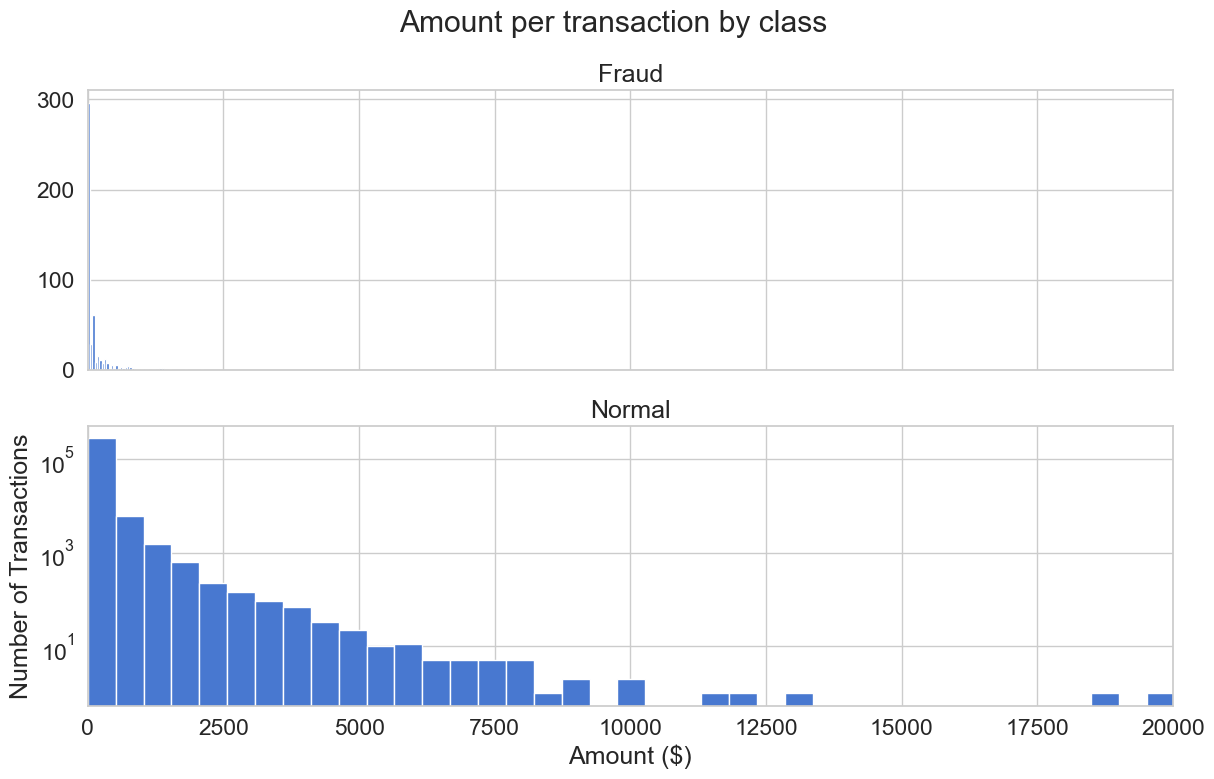

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)   # 1st histogram
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)   # 2nd histogram
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

### Plotting time of transaction to check for correlations using Scatterplot

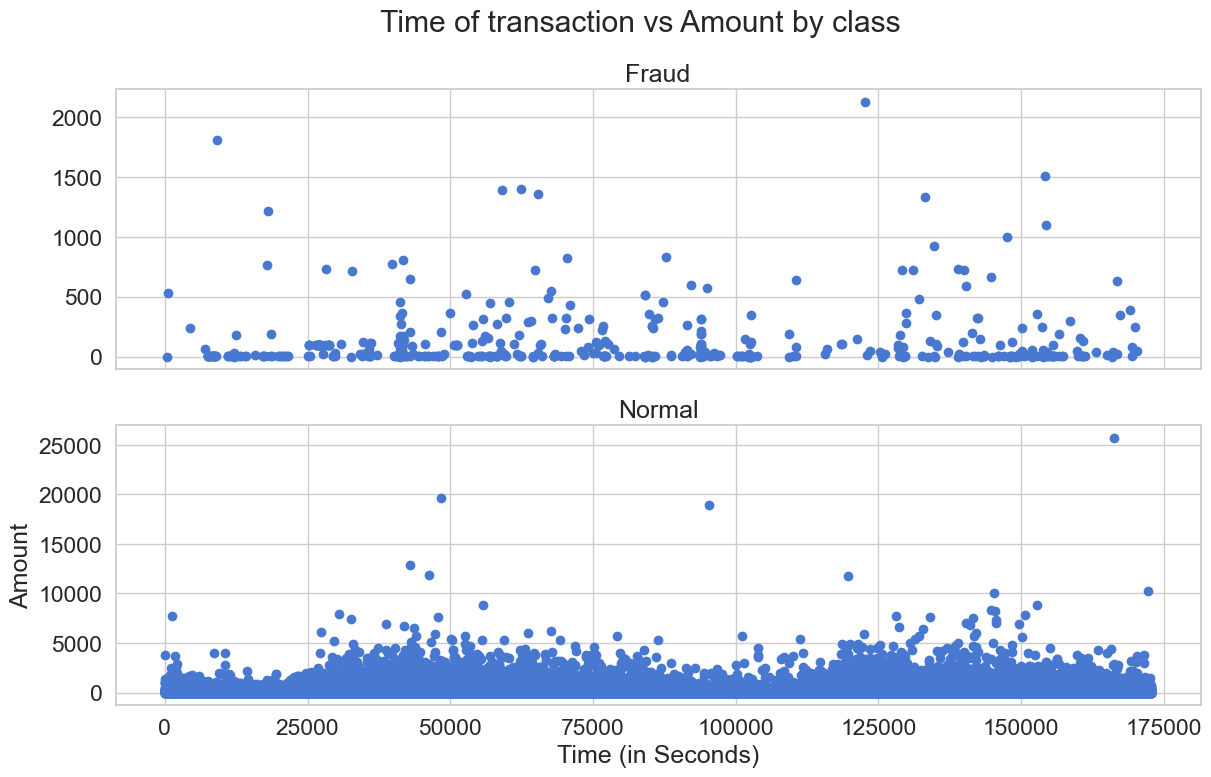

In [20]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [21]:
data = df.drop(['Time'], axis=1)   # remove d stated column

## Scaling only Amount column using StandardScaler

In [22]:
from sklearn.preprocessing import StandardScaler

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Building the model

In [23]:
# Lets create separate dataframes for each unique values in Class column
non_fraud = data[data['Class'] == 0] #.sample(1000)

fraud = data[data['Class'] == 1]

In [24]:
print(fraud.shape)
print(non_fraud.shape)

(492, 30)
(284315, 30)


In [26]:
# Join both dataframes together and use only a sample % of d entire data rather than d entire data
df = non_fraud._append(fraud).sample(frac=1).reset_index(drop=True)
df.shape

(284807, 30)

In [27]:
# Define response and predictors
X = df.drop(['Class'], axis = 1).values    # removes d stated column

Y = df["Class"].values

## Spliting the data into 80% training and 20% testing

In [28]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

# New dataframes
X_train_fraud = X_train[X_train.Class == 1]
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape

(227451, 29)

## Autoencoder model

In [29]:
# input layer
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

## Training the credit card fraud detection model

In [30]:
autoencoder = Model(input_layer, output_layer)

autoencoder.compile(optimizer="adadelta", loss="mse")

## Scaling the values

In [31]:
x = data.drop(["Class"], axis=1)

y = data["Class"].values

In [32]:
x_scale = MinMaxScaler().fit_transform(x.values)

x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Epoch 1/10
7/7 [==============================] - 16s 297ms/step - loss: 0.2476 - val_loss: 0.2466
Epoch 2/10
7/7 [==============================] - 0s 67ms/step - loss: 0.2472 - val_loss: 0.2462
Epoch 3/10
7/7 [==============================] - 1s 76ms/step - loss: 0.2468 - val_loss: 0.2457
Epoch 4/10
7/7 [==============================] - 0s 59ms/step - loss: 0.2463 - val_loss: 0.2453
Epoch 5/10
7/7 [==============================] - 0s 69ms/step - loss: 0.2459 - val_loss: 0.2448
Epoch 6/10
7/7 [==============================] - 0s 61ms/step - loss: 0.2454 - val_loss: 0.2444
Epoch 7/10
7/7 [==============================] - 0s 65ms/step - loss: 0.2450 - val_loss: 0.2439
Epoch 8/10
7/7 [==============================] - 0s 69ms/step - loss: 0.2445 - val_loss: 0.2434
Epoch 9/10
7/7 [==============================] - 0s 55ms/step - loss: 0.2440 - val_loss: 0.2430
Epoch 10/10
7/7 [==============================] - 1s 204ms/step - loss: 0.2435 - val_loss: 0.2425


# Obtain the Hidden Representation

In [33]:
hidden_representation = Sequential()

hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

## Model Prediction

In [34]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])

fraud_hid_rep = hidden_representation.predict(x_fraud)

16/16 [==============================] - 0s 9ms/step


## Getting the representation data

In [35]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)   # combining both objects by columns

y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])

rep_y = np.append(y_n, y_f)

## Train, Test, Split

In [36]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)

## Credit Card Fraud Detection Prediction model

In [37]:
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)


In [38]:
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.98       735
         1.0       1.00      0.75      0.85       138

    accuracy                           0.96       873
   macro avg       0.98      0.87      0.92       873
weighted avg       0.96      0.96      0.96       873


Accuracy Score:  0.9599083619702177
